In [1]:
import pymongo
client=pymongo.MongoClient('192.168.1.113',27017,username="j122085",password="850605")
db=client.rawData
print(db.collection_names())
collection=db.wowprimediendata
wowDatas=list(collection.find({"avgDailyCustomer":{"$gte":0},"avgDailyNet":{"$gte":0},"costPower_Analyze":{"$gte":0}}))

['busData', 'HRdata104', 'wowprimediendata', 'info591', 'departmentStore', 'websites591', 'taiwanInfo', 'smallStyleCount', 'addressCoordinate', 'Nhuman', 'ipeenWebsite', 'bigStyleCount', 'ipeenInfo', 'conStore', 'CostPower']


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
df=pd.DataFrame(wowDatas)
df.salary = df.avgDailyCustomer.astype(float)                   #traform into float type
df.working = df.avgDailyNet.astype(float)                 #traform into float type
X = df[['costPower_Analyze','Nhuman_Analyze','NbusStation_Analyze','NconStore_Analyze','Nstar_Analyze', 'Nmc_Analyze', 'Nken_Analyze','Nwa_Analyze']].values                   #tranform DataFrame to ndarray Matrix  為了predict輸入的方式
xx=X

#將每個欄位的數值都變成0-1(除以最大的數做正規化、並只留下該數值List) 
# x=[]
# for i in range(len(X.T)):
#     x.append(X.T[i]/max(X.T[i]))

#用zscore正規化
x=[]
def zscore(x, axis = None):
    x=np.array(x)
    xmean = x.mean(axis=axis, keepdims=True)
    xstd  = np.std(x, axis=axis, keepdims=True)
    zscore = (x-xmean)/xstd
    return zscore    

for i in range(len(X.T)):
    x.append(zscore(X.T[i]))
    
    
    
x=np.array(x)
X=x.T




In [14]:
xx.shape

(262, 8)

In [5]:
len(X)

262

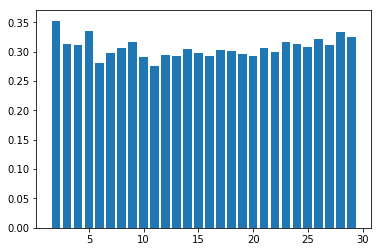

[0.3528776818392792, 0.313376632636772, 0.3120219395686604, 0.33510481441495665, 0.2808387605735008, 0.2984346343601335, 0.3061789847572313, 0.31606771265927874, 0.2908479075974104, 0.27601095126021064, 0.2947064261729579, 0.29255637927123074, 0.3045895155125618, 0.29871399687453704, 0.2929742371698637, 0.30240394880452925, 0.30189455060923626, 0.29663233331053257, 0.29238879648556926, 0.30655794270146597, 0.2987539357103899, 0.31641793755903114, 0.31242475572496875, 0.30748054251988177, 0.3222902692258987, 0.3106480818983823, 0.33336377105918674, 0.32572580295052295]


In [6]:
from sklearn import cluster, datasets, metrics
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
# 印出效用最高的kmeans群
silhouette_avgs = []
ks = range(2, 30)
for k in ks:
    kmeans_fit = cluster.KMeans(n_clusters = k).fit(X)
    cluster_labels = kmeans_fit.labels_
    silhouette_avg = metrics.silhouette_score(X, cluster_labels) #組間變異
    silhouette_avgs.append(silhouette_avg)

# 作圖並印出 k = 2 到 10 的績效
plt.bar(ks, silhouette_avgs)
plt.show()
print(silhouette_avgs)

In [7]:
km = KMeans(n_clusters=5)  #K=2群
y_pred = km.fit_predict(X)
# plt.figure(figsize=(10, 6))
# plt.xlabel('ADS')
# plt.ylabel('ADGC')
# plt.scatter(X[:, 0], X[:, 1], c=y_pred) #C是第三維度 已顏色做維度
# plt.show()
# km.cluster_centers_ #各群中心點(X,Y)的位置

#km.labels_是分群結果list、加入資料中
TwowDatas=[i for i in wowDatas if 'avgDailyCustomer' in i and "avgDailyNet" in i and 'costPower_Analyze' in i]
for i,j in zip(km.labels_,TwowDatas):
    j['cluster']=i

In [48]:
#匯出成excel
dfNew=pd.DataFrame(TwowDatas)
wr=pd.ExcelWriter("ClusterWow2.xlsx")
dfNew.to_excel(wr)
wr.save()


In [52]:
x=0
for i in np.around(km.cluster_centers_,1):
    print("第{}群資料中心".format(x),list(i),sep="\n")
    x+=1

第0群資料中心
[1.2, 1.4, 0.2, 2.0, 2.3, 2.0, 1.4, 1.3]
第1群資料中心
[-0.5, -0.9, -0.6, -0.9, -0.6, -0.8, -0.7, -0.8]
第2群資料中心
[1.1, 0.4, 0.1, 0.2, 0.3, 0.6, -0.3, 0.0]
第3群資料中心
[0.1, -0.2, 2.8, 0.0, -0.4, -0.2, 0.8, -0.4]
第4群資料中心
[-0.6, 0.5, 0.1, 0.2, -0.3, -0.1, 0.4, 0.7]


In [24]:
#看看每群的feature分布
xxx=['avgDailyNet','avgDailyCustomer','costPower_Analyze','Nhuman_Analyze','NbusStation_Analyze','NconStore_Analyze','Nstar_Analyze', 'Nmc_Analyze', 'Nken_Analyze','Nwa_Analyze']
clusterData={}
for n in range(len(set(km.labels_))):
    clusterData[n]={}
    for i in [d for d in TwowDatas if d['cluster']==n]:
        for j in xxx:
            if i[j] >clusterData[n].get(j+"_max",0):
                clusterData[n][j+"_max"]=i[j]
            if i[j] <clusterData[n].get(j+"_min",5000000000):
                clusterData[n][j+"_min"]=i[j]
import pprint
pprint.pprint(clusterData)

{0: {'NbusStation_Analyze_max': 31,
     'NbusStation_Analyze_min': 0,
     'NconStore_Analyze_max': 79,
     'NconStore_Analyze_min': 14,
     'Nhuman_Analyze_max': 119859,
     'Nhuman_Analyze_min': 34601,
     'Nken_Analyze_max': 3,
     'Nken_Analyze_min': 0,
     'Nmc_Analyze_max': 6,
     'Nmc_Analyze_min': 0,
     'Nstar_Analyze_max': 6,
     'Nstar_Analyze_min': 0,
     'Nwa_Analyze_max': 2,
     'Nwa_Analyze_min': 0,
     'avgDailyCustomer_max': 392,
     'avgDailyCustomer_min': 88,
     'avgDailyNet_max': 191180,
     'avgDailyNet_min': 42095,
     'costPower_Analyze_max': 82.0,
     'costPower_Analyze_min': 27.0},
 1: {'NbusStation_Analyze_max': 38,
     'NbusStation_Analyze_min': 5,
     'NconStore_Analyze_max': 214,
     'NconStore_Analyze_min': 76,
     'Nhuman_Analyze_max': 268863,
     'Nhuman_Analyze_min': 200337,
     'Nken_Analyze_max': 4,
     'Nken_Analyze_min': 0,
     'Nmc_Analyze_max': 13,
     'Nmc_Analyze_min': 2,
     'Nstar_Analyze_max': 16,
     'Nstar_Anal

In [11]:
Y=df['avgDailyCustomer'].values
len(Y)

262

In [12]:
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers.core import Dense,Activation
from keras.utils import np_utils
import pymongo

In [24]:
input_size=8#feature數量
batch_size=50#每批樣本大小
epochs=500#處理幾輪

model=Sequential()  #定義model
model.add(Dense(20,input_dim=input_size)) 
model.add(Activation('relu')) #啟動函數
model.add(Dense(50)) 
model.add(Activation('relu')) #啟動函數
model.add(Dense(40)) 
model.add(Activation('relu')) #啟動函數
model.add(Dense(20)) 
model.add(Activation('linear')) #啟動函數
model.add(Dense(1))  #加入層(緊密層) 產出個數10.輸入個數100 次元
# model.add(Activation("linear"))
# model.compile(loss="MSE",metrics=['accuracy'],optimizer='sgd')


#loss成本函數mse(均方差)  optimizer最佳化工具sgd(梯度下降)
# model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.fit(xx,Y,batch_size=batch_size,nb_epoch=epochs,verbose=1)


score=model.evaluate(xx,Y,verbose=1)
print('Test accuracy:',score[1])


newData=[[int(j)for j in i.split("\t")] for i in """63	282141	204	187	16	14	2	1""".split('\n')]
model.predict(np.array(newData).astype('float32'))

D:\anaconda\lib\site-packages\keras\models.py:939: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Epoch 1/500
262/262 [==============================] - 1s 2ms/step - loss: 2701791.3428 - mean_absolute_error: 1329.7594
Epoch 2/500
262/262 [==============================] - 0s 38us/step - loss: 961863.4950 - mean_absolute_error: 743.6562
Epoch 3/500
262/262 [==============================] - 0s 34us/step - loss: 592070.8711 - mean_absolute_error: 651.4019
Epoch 4/500
262/262 [==============================] - 0s 50us/step - loss: 323969.6035 - mean_absolute_error: 466.6033
Epoch 5/500
262/262 [==============================] - 0s 42us/step - loss: 154098.0456 - mean_absolute_error: 289.9723
Epoch 6/500
262/262 [==============================] - 0s 34us/step - loss: 114005.5573 - mean_absolute_error: 293.4581
Epoch 7/500
262/262 [==============================] - 0s 34us/step - loss: 109762.0204 - mean_absolute_error: 275.3552
Epoch 8/500
262/262 [==============================] - 0s 57us/step - loss: 50641.0703 - mean_absolute_error: 170.6889
Epoch 9/500
262/262 [===================

262/262 [==============================] - 0s 34us/step - loss: 22280.5551 - mean_absolute_error: 123.6663
Epoch 68/500
262/262 [==============================] - 0s 50us/step - loss: 26174.9534 - mean_absolute_error: 133.0811
Epoch 69/500
262/262 [==============================] - 0s 34us/step - loss: 41115.8050 - mean_absolute_error: 166.8806
Epoch 70/500
262/262 [==============================] - 0s 34us/step - loss: 22044.4639 - mean_absolute_error: 122.1582
Epoch 71/500
262/262 [==============================] - 0s 34us/step - loss: 19473.6809 - mean_absolute_error: 115.9381
Epoch 72/500
262/262 [==============================] - 0s 34us/step - loss: 28560.5866 - mean_absolute_error: 133.6952
Epoch 73/500
262/262 [==============================] - ETA: 0s - loss: 42426.5117 - mean_absolute_error: 190.548 - 0s 38us/step - loss: 25975.6381 - mean_absolute_error: 133.5441
Epoch 74/500
262/262 [==============================] - 0s 46us/step - loss: 21182.3339 - mean_absolute_error: 12

262/262 [==============================] - 0s 38us/step - loss: 32273.9137 - mean_absolute_error: 150.2253
Epoch 134/500
262/262 [==============================] - 0s 34us/step - loss: 57754.5526 - mean_absolute_error: 207.3989
Epoch 135/500
262/262 [==============================] - 0s 42us/step - loss: 93515.4466 - mean_absolute_error: 236.8752
Epoch 136/500
262/262 [==============================] - 0s 34us/step - loss: 40578.0739 - mean_absolute_error: 167.9755
Epoch 137/500
262/262 [==============================] - 0s 34us/step - loss: 35005.0460 - mean_absolute_error: 159.5309
Epoch 138/500
262/262 [==============================] - 0s 34us/step - loss: 28581.8482 - mean_absolute_error: 136.5276
Epoch 139/500
262/262 [==============================] - 0s 34us/step - loss: 20852.2989 - mean_absolute_error: 118.9481
Epoch 140/500
262/262 [==============================] - 0s 34us/step - loss: 24527.8329 - mean_absolute_error: 132.6542
Epoch 141/500
262/262 [=======================

262/262 [==============================] - 0s 34us/step - loss: 25370.7598 - mean_absolute_error: 131.0167
Epoch 200/500
262/262 [==============================] - 0s 34us/step - loss: 59680.5462 - mean_absolute_error: 202.2169
Epoch 201/500
262/262 [==============================] - 0s 34us/step - loss: 106055.0108 - mean_absolute_error: 259.7163
Epoch 202/500
262/262 [==============================] - 0s 38us/step - loss: 49415.5274 - mean_absolute_error: 186.5012
Epoch 203/500
262/262 [==============================] - 0s 38us/step - loss: 33224.1396 - mean_absolute_error: 152.8404
Epoch 204/500
262/262 [==============================] - 0s 31us/step - loss: 28409.0349 - mean_absolute_error: 141.8029
Epoch 205/500
262/262 [==============================] - 0s 34us/step - loss: 24232.8356 - mean_absolute_error: 127.9943
Epoch 206/500
262/262 [==============================] - 0s 34us/step - loss: 20026.3299 - mean_absolute_error: 116.3705
Epoch 207/500
262/262 [======================

262/262 [==============================] - 0s 34us/step - loss: 26770.2444 - mean_absolute_error: 132.0012
Epoch 267/500
262/262 [==============================] - 0s 34us/step - loss: 37648.3582 - mean_absolute_error: 165.6628
Epoch 268/500
262/262 [==============================] - 0s 34us/step - loss: 27531.3367 - mean_absolute_error: 133.3379
Epoch 269/500
262/262 [==============================] - 0s 31us/step - loss: 24619.6463 - mean_absolute_error: 132.0498
Epoch 270/500
262/262 [==============================] - 0s 50us/step - loss: 37664.2074 - mean_absolute_error: 165.8131
Epoch 271/500
262/262 [==============================] - 0s 34us/step - loss: 34610.9778 - mean_absolute_error: 156.1986
Epoch 272/500
262/262 [==============================] - 0s 31us/step - loss: 31983.1431 - mean_absolute_error: 148.4079
Epoch 273/500
262/262 [==============================] - 0s 38us/step - loss: 22881.8822 - mean_absolute_error: 125.2296
Epoch 274/500
262/262 [=======================

262/262 [==============================] - 0s 31us/step - loss: 30683.9912 - mean_absolute_error: 145.6322
Epoch 333/500
262/262 [==============================] - 0s 34us/step - loss: 24647.2062 - mean_absolute_error: 127.6530
Epoch 334/500
262/262 [==============================] - ETA: 0s - loss: 22721.2656 - mean_absolute_error: 122.268 - 0s 34us/step - loss: 18642.5430 - mean_absolute_error: 112.1270
Epoch 335/500
262/262 [==============================] - 0s 38us/step - loss: 19703.9179 - mean_absolute_error: 113.6000
Epoch 336/500
262/262 [==============================] - 0s 34us/step - loss: 31466.3245 - mean_absolute_error: 146.0696
Epoch 337/500
262/262 [==============================] - ETA: 0s - loss: 18423.4180 - mean_absolute_error: 112.980 - 0s 34us/step - loss: 23540.7098 - mean_absolute_error: 125.2433
Epoch 338/500
262/262 [==============================] - 0s 34us/step - loss: 24878.8328 - mean_absolute_error: 129.1388
Epoch 339/500
262/262 [========================

262/262 [==============================] - 0s 34us/step - loss: 23455.9681 - mean_absolute_error: 127.8700
Epoch 399/500
262/262 [==============================] - 0s 31us/step - loss: 35794.4284 - mean_absolute_error: 155.9104
Epoch 400/500
262/262 [==============================] - 0s 38us/step - loss: 28006.9631 - mean_absolute_error: 140.0860
Epoch 401/500
262/262 [==============================] - 0s 53us/step - loss: 39014.4094 - mean_absolute_error: 155.4438
Epoch 402/500
262/262 [==============================] - 0s 34us/step - loss: 45790.1733 - mean_absolute_error: 176.9795
Epoch 403/500
262/262 [==============================] - 0s 38us/step - loss: 21308.2287 - mean_absolute_error: 119.2957
Epoch 404/500
262/262 [==============================] - 0s 34us/step - loss: 31994.5102 - mean_absolute_error: 152.1065
Epoch 405/500
262/262 [==============================] - 0s 34us/step - loss: 31832.6533 - mean_absolute_error: 149.4273
Epoch 406/500
262/262 [=======================

262/262 [==============================] - 0s 34us/step - loss: 30084.2367 - mean_absolute_error: 146.3894
Epoch 465/500
262/262 [==============================] - 0s 34us/step - loss: 35101.0211 - mean_absolute_error: 156.1191
Epoch 466/500
262/262 [==============================] - 0s 34us/step - loss: 29141.1015 - mean_absolute_error: 143.2376
Epoch 467/500
262/262 [==============================] - 0s 38us/step - loss: 22712.5249 - mean_absolute_error: 125.2388
Epoch 468/500
262/262 [==============================] - 0s 42us/step - loss: 22674.2091 - mean_absolute_error: 121.1787
Epoch 469/500
262/262 [==============================] - 0s 38us/step - loss: 29144.3233 - mean_absolute_error: 144.8817
Epoch 470/500
262/262 [==============================] - 0s 34us/step - loss: 43264.6855 - mean_absolute_error: 175.2987
Epoch 471/500
262/262 [==============================] - 0s 34us/step - loss: 31421.7006 - mean_absolute_error: 144.4612
Epoch 472/500
262/262 [=======================

array([[220.66396]], dtype=float32)

In [25]:
model.predict(xx)

array([[177.21571 ],
       [166.43642 ],
       [284.00378 ],
       [151.90419 ],
       [271.2694  ],
       [144.43544 ],
       [ 77.574104],
       [111.68348 ],
       [121.36219 ],
       [235.10243 ],
       [ 83.74061 ],
       [282.33386 ],
       [188.26064 ],
       [ 69.45838 ],
       [ 60.391243],
       [ 67.17518 ],
       [ 87.86854 ],
       [134.26357 ],
       [217.96962 ],
       [164.44032 ],
       [184.78505 ],
       [153.1161  ],
       [245.4999  ],
       [210.93642 ],
       [244.87001 ],
       [156.00185 ],
       [128.01259 ],
       [262.93542 ],
       [259.81042 ],
       [200.10341 ],
       [141.75868 ],
       [135.22353 ],
       [232.4999  ],
       [292.27527 ],
       [296.30457 ],
       [277.57214 ],
       [132.69228 ],
       [216.5663  ],
       [166.97157 ],
       [ 62.495735],
       [239.55263 ],
       [119.92957 ],
       [ 56.345345],
       [ 73.716194],
       [ 65.624886],
       [ 90.75623 ],
       [ 77.1056  ],
       [ 47.7

In [27]:
import numpy as np
newData=[[int(j)for j in i.split("\t")] for i in """54	116765	2	56	2	4	2	0
76	184357	10	120	7	11	0	1
56	368003	8	186	7	6	3	2
80	223093	12	116	12	13	1	2
52	137707	10	78	0	2	0	0
54	286210	14	136	0	2	2	0
56	365344	8	184	8	6	3	3
63	282141	22	187	16	14	2	1""".split('\n')]
to_be_predicted = np.array(newData)
predicted_sales = model.predict(to_be_predicted)
predicted_sales

array([[ 93.96131],
       [140.1122 ],
       [260.55457],
       [166.93153],
       [108.10926],
       [208.14345],
       [258.67957],
       [202.23329]], dtype=float32)

In [ ]:
#存取model
from keras.models import model_from_json

#將model格式轉換成json字串，並且將其存成文字檔
json_string = model.to_json()
with open("modelJsonString",'w') as f:
    f.write(json_string)
    
#將model的訓練weight存程某檔案('modelWeight')
model.save_weights('modelWeight')

In [3]:
#讀取過去存放的資料
from keras.models import Sequential
model=Sequential()
from keras.models import model_from_json
with open("modelJsonString",'r') as f:
    json_string=f.read()

model = model_from_json(json_string)
model.load_weights('modelWeight', by_name=False)

In [ ]:
#http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
data=[[i['NbusStation_Analyze'],
  i['NconStore_Analyze'],
  i['costPower_Analyze'],
  i['Nhuman_Analyze']]for i in wowDatas if 'NbusStation_Analyze' in i and 'avgDailyCustomer' in i and 'costPower_Analyze' in i]

In [ ]:
data=[[i['Nstar_Analyze'],
  i['NconStore_Analyze'],
  i['Nmc_Analyze'],
  i['Nken_Analyze']]for i in wowDatas if 'NbusStation_Analyze' in i and 'avgDailyCustomer' in i]

In [ ]:
data=[[i['NbusStation_Analyze'],
  i['NconStore_Analyze'],
  i['costPower_Analyze'],
  i['Nhuman_Analyze'],
  i['Nstar_Analyze'],
  i['Nmc_Analyze'],
  i['Nken_Analyze']]for i in wowDatas if 'NbusStation_Analyze' in i and 'avgDailyCustomer' in i and 'costPower_Analyze' in i]

In [ ]:
mC=max([i['avgDailyCustomer'] for i in wowDatas if 'NbusStation_Analyze' in i and 'avgDailyCustomer' in i and 'costPower_Analyze' in i])
mN=max([i['avgDailyNet'] for i in wowDatas if 'NbusStation_Analyze' in i and 'avgDailyCustomer' in i and 'costPower_Analyze' in i])

In [ ]:
data=[[i['avgDailyNet']/mN,
  i['avgDailyCustomer']/mC] for i in wowDatas if 'NbusStation_Analyze' in i and 'avgDailyCustomer' in i and 'costPower_Analyze' in i]

In [ ]:
X = np.array(data)
from sklearn import cluster, datasets, metrics
import matplotlib.pyplot as plt

# 迴圈
silhouette_avgs = []
ks = range(2, 40)
for k in ks:
    kmeans_fit = cluster.KMeans(n_clusters = k).fit(X)
    cluster_labels = kmeans_fit.labels_
    silhouette_avg = metrics.silhouette_score(X, cluster_labels)
    silhouette_avgs.append(silhouette_avg)

# 作圖並印出 k = 2 到 10 的績效
plt.bar(ks, silhouette_avgs)
plt.show()
print(silhouette_avgs)

In [ ]:
from sklearn.cluster import KMeans
import numpy as np
X = np.array(data)
kmeans = KMeans(n_clusters=7, random_state=0).fit(X)
kmeans.labels_

In [ ]:
kmeans.cluster_centers_

In [ ]:
mainData=[i for i in wowDatas if 'NbusStation_Analyze' in i and 'avgDailyCustomer' in i and 'costPower_Analyze' in i]

In [ ]:
for i,j in zip(mainData,list(kmeans.labels_)):
    i['k']=j

In [ ]:
mainData[0]

In [ ]:
for k in range(0,51):
    print(k,[i['Called'] for i in mainData if i['k']==k])
    print("="*50)
    #'avgDailyCustomer' 'Called' 'avgDailyNet'

In [ ]:
[[i['NbusStation_Analyze'],
  i['NconStore_Analyze'],
  i['costPower_Analyze'],
  i['Nhuman_Analyze'],
  i['Nstar_Analyze'],
  i['Nmc_Analyze'],
  i['Nken_Analyze'],
  i['Called'],
  i['avgDailyNet'],
  i['avgDailyCustomer']
  ] for i in mainData if i['k']==2]

# try linear(回歸)

In [57]:
import pymongo
client=pymongo.MongoClient('192.168.1.113',27017,username="j122085",password="850605")

db=client.rawData
print(db.collection_names())
collection=db.wowprimediendata
wowDatas=list(collection.find({}))


store=input("輸入店家")
import numpy as np
from sklearn.linear_model import LinearRegression
X= np.array([[i['costPower_Analyze'],
              i['Nhuman_Analyze'],
              i['NbusStation_Analyze'],
              i['NconStore_Analyze'],
              i['Nstar_Analyze'],
              i['Nmc_Analyze'],
              i['Nken_Analyze'],
              i['Nwa_Analyze']]for i in wowDatas if 'NbusStation_Analyze' in i and 'avgDailyCustomer' in i and 'costPower_Analyze' in i
            and i['Called']==store])

#,  i['Nstar_Analyze'],  i['Nmc_Analyze'],  i['Nken_Analyze'],  i['costPower_Analyze'],    i['Nhuman_Analyze'],    i['NbusStation_Analyze']  i['NconStore_Analyze']

Y= np.array([i['avgDailyCustomer'] for i in wowDatas if 'NbusStation_Analyze' in i and 'avgDailyCustomer' in i and 'costPower_Analyze' in i
            and i['Called']==store])

#'avgDailyCustomer' 'Called' 'avgDailyNet'

lm = LinearRegression()
lm.fit(X, Y)

# 印出係數
print(lm.coef_)
print('消費力	人口數	公車站數	四大超商數	星巴克數	麥當勞數	肯德基數	瓦城數')
# # 印出截距
# print(lm.intercept_ )


['busData', 'HRdata104', 'wowprimediendata', 'departmentStore', 'smallStyleCount', 'addressCoordinate', 'Nhuman', 'ipeenWebsite', 'bigStyleCount', 'ipeenInfo', 'conStore', 'CostPower']
輸入店家陶板屋
[-1.32053372e-01  5.42304576e-04  5.43177383e-01 -8.40539381e-01
  3.41329777e+00  2.54802525e-01  1.13285306e+01 -1.15484502e+01]
消費力	人口數	公車站數	四大超商數	星巴克數	麥當勞數	肯德基數	瓦城數


In [ ]:
# x=[int(i) for i in "58	176822	182	130	3	5	3	1".split("\t")]
# 新店資料
newData=[[int(j)for j in i.split("\t")] for i in """25\t17957\t75\t49\t0\t0\t0\t0""".split('\n')]


to_be_predicted = np.array(newData)

predicted_sales = lm.predict(to_be_predicted)

# 預測新店的客量
print(predicted_sales)

In [ ]:
# {'CooK BEEF!',
#  'hot 7',
#  'ita義塔',
#  '乍牛',
#  '原燒',
#  '品田牧場',
#  '夏慕尼',
#  '沐越',
#  '王品',
#  '石二鍋',
#  '聚',
#  '舒果',
#  '莆田',
#  '藝奇',
#  '陶板屋',
#  '青花驕',
#  '麻佬大',
#  'ＴＡＳＴｙ'}

# try neural_network (sklearn)

In [61]:
from sklearn.neural_network.multilayer_perceptron import MLPClassifier
# from sklearn.neural_network.multilayer_perceptron import MLPRegressor

In [63]:
import pymongo
client=pymongo.MongoClient('192.168.1.113',27017,username="j122085",password="850605")

db=client.rawData
print(db.collection_names())
collection=db.wowprimediendata
wowDatas=list(collection.find({}))

Calls=set(i["Called"] for i in wowDatas)
for Call in Calls:
    mean=np.mean([i["avgDailyCustomer"] for i in wowDatas if i["Called"]==Call and 'avgDailyCustomer' in i])
    if not np.isnan(mean):
        for j in wowDatas:
            if j["Called"]==Call and 'avgDailyCustomer' in j:
                if j["avgDailyCustomer"]>mean*1.1:
                    j['type']=0#"good"
                elif j["avgDailyCustomer"]<mean*0.9:
                    j['type']=2#"bad"
                else:
                    j['type']=1#"normal"
            if 'avgDailyCustomer' in j:
                aC=j["avgDailyNet"]/j["avgDailyCustomer"]
                if aC<290:
                    j['typeP']="低"
                elif aC<450:
                    j['typeP']="中"
                elif aC<800:
                    j['typeP']="中高"
                else:
                    j['typeP']="高"
                

store=input("輸入店家")
import numpy as np
from sklearn.linear_model import LinearRegression
X= np.array([[i['costPower_Analyze'],
              i['Nhuman_Analyze'],
              i['NbusStation_Analyze'],
              i['NconStore_Analyze'],
              i['Nstar_Analyze'], 
              i['Nmc_Analyze'], 
              i['Nken_Analyze'],
              i['Nwa_Analyze']]for i in wowDatas if 'NbusStation_Analyze' in i and 'avgDailyCustomer' in i and 'costPower_Analyze' in i
#             ])
#             and i['Called']==store])
              and i['typeP']==store])


# ,
#               i['Nstar_Analyze'], 
#               i['Nmc_Analyze'], 
#               i['Nken_Analyze'],
#               i['Nwa_Analyze']
#,  i['Nstar_Analyze'],  i['Nmc_Analyze'],  i['Nken_Analyze'],  i['costPower_Analyze'],    i['Nhuman_Analyze'],    i['NbusStation_Analyze']  i['NconStore_Analyze']

Y= np.array([i['type'] for i in wowDatas if 'NbusStation_Analyze' in i and 'avgDailyCustomer' in i and 'costPower_Analyze' in i
#             ])
#             and i['Called']==store])
             and i['typeP']==store])
#avgDailyCustomer 'type'


['busData', 'HRdata104', 'wowprimediendata', 'departmentStore', 'smallStyleCount', 'addressCoordinate', 'Nhuman', 'ipeenWebsite', 'bigStyleCount', 'ipeenInfo', 'conStore', 'CostPower']


D:\anaconda\lib\site-packages\numpy\core\fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
D:\anaconda\lib\site-packages\numpy\core\_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


輸入店家低


In [65]:
from sklearn.cross_validation import train_test_split
#將資料分成訓練、測試集 其中測試集佔三成
data_train, data_test, labels_train, labels_test =train_test_split(X,Y,test_size=0.3,random_state=1)

from sklearn.preprocessing import StandardScaler
#對數據做正規化的動作(減去平均值、縮放成一單位)，可以改進效能!!!
scarler=StandardScaler()
scarler.fit(X)
data_train_std=scarler.transform(data_train)
data_test_std=scarler.transform(data_test)

D:\anaconda\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [66]:
# mlp=MLPClassifier(random_state=1)
mlp=MLPClassifier(random_state=1,hidden_layer_sizes=(200,500,300),activation="relu",max_iter=500)
# mlp=MLPClassifier(random_state=1,hidden_layer_sizes=(1000,1000,1000,1000,1000),activation="relu",max_iter=800)

# mlp=MLPRegressor(random_state=1,hidden_layer_sizes=(200,500,300),activation="relu",max_iter=500)

mlp.fit(data_train_std,labels_train)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(200, 500, 300), learning_rate='constant',
       learning_rate_init=0.001, max_iter=500, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
       solver='adam', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

In [74]:
from sklearn.metrics import accuracy_score
#本身
pred=mlp.predict(data_train_std)
print("自己")
print("Misclassified samples: {}".format((labels_train != pred).sum()))
print("Accuracy: {}".format(accuracy_score(labels_train,pred)))

print("="*50)
#預測
print("測試")
pred=mlp.predict(data_test_std)
print("Misclassified samples: {}".format((labels_test != pred).sum()))
print("Accuracy: {}".format(accuracy_score(labels_test,pred)))

自己
Misclassified samples: 0
Accuracy: 1.0
測試
Misclassified samples: 16
Accuracy: 0.15789473684210525


In [75]:
pred

array([2, 2, 2, 2, 2, 2, 0, 2, 0, 1, 2, 1, 0, 1, 0, 2, 1, 2, 0])

In [76]:
newData=[[int(j)for j in i.split("\t")] for i in """52	102316	0	49	2	4	2	0
56	178949	12	125	5	8	5	3
58	185640	39	132	3	5	3	1
67	373797	11	229	31	16	2	3
70	353804	11	252	30	14	4	2
51	106274	7	39	1	2	2	0
60	185182	42	134	3	5	4	1
52	303312	7	119	7	6	1	0
65	342102	20	171	13	11	3	2
53	78571	11	42	0	1	1	0
50	330930	19	199	5	5	5	2
64	233683	13	154	11	7	3	1
65	64577	11	27	1	3	1	0
58	256929	9	145	4	7	2	2""".split('\n')]
# 新店資料

newData_std=scarler.transform(newData)


# print('消費力	人口數	公車站數	四大超商數	星巴克數	麥當勞數	肯德基數	瓦城數')

to_be_predicted = np.array(newData_std)
predicted_sales=mlp.predict(to_be_predicted)
predicted_sales

array([0, 1, 0, 2, 2, 2, 0, 2, 0, 2, 1, 2, 1, 0])

# try keras neural network

In [77]:
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers.core import Dense,Activation
from keras.utils import np_utils
import pymongo


D:\anaconda\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [78]:
import pymongo
client=pymongo.MongoClient('192.168.1.113',27017,username="j122085",password="850605")

db=client.rawData
print(db.collection_names())
collection=db.wowprimediendata
wowDatas=list(collection.find({}))

Calls=set(i["Called"] for i in wowDatas)
for Call in Calls:
    mean=np.mean([i["avgDailyCustomer"] for i in wowDatas if i["Called"]==Call and 'avgDailyCustomer' in i])
    if not np.isnan(mean):
        for j in wowDatas:
            if j["Called"]==Call and 'avgDailyCustomer' in j:
                if j["avgDailyCustomer"]>mean*1.1:
                    j['type']=0#"good"
                elif j["avgDailyCustomer"]<mean*0.9:
                    j['type']=2#"bad"
                else:
                    j['type']=1#"normal"
            if 'avgDailyCustomer' in j:
                aC=j["avgDailyNet"]/j["avgDailyCustomer"]
                if aC<290:
                    j['typeP']="低"
                elif aC<450:
                    j['typeP']="中"
                elif aC<800:
                    j['typeP']="中高"
                else:
                    j['typeP']="高"
                

store=input("輸入店家")
import numpy as np
from sklearn.linear_model import LinearRegression
X= np.array([[i['costPower_Analyze'],
              i['Nhuman_Analyze'],
              i['NbusStation_Analyze'],
              i['NconStore_Analyze'],
              i['Nstar_Analyze'], 
              i['Nmc_Analyze'], 
              i['Nken_Analyze'],
              i['Nwa_Analyze']]for i in wowDatas if 'NbusStation_Analyze' in i and 'avgDailyCustomer' in i and 'costPower_Analyze' in i
#             ])
#             and i['Called']==store])
              and i['typeP']==store])


# ,
#               i['Nstar_Analyze'], 
#               i['Nmc_Analyze'], 
#               i['Nken_Analyze'],
#               i['Nwa_Analyze']
#,  i['Nstar_Analyze'],  i['Nmc_Analyze'],  i['Nken_Analyze'],  i['costPower_Analyze'],    i['Nhuman_Analyze'],    i['NbusStation_Analyze']  i['NconStore_Analyze']

Y= np.array([i['type'] for i in wowDatas if 'NbusStation_Analyze' in i and 'avgDailyCustomer' in i and 'costPower_Analyze' in i
#             ])
#             and i['Called']==store])
             and i['typeP']==store])
#avgDailyCustomer 'type'


D:\anaconda\lib\site-packages\numpy\core\fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
D:\anaconda\lib\site-packages\numpy\core\_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


['busData', 'HRdata104', 'wowprimediendata', 'departmentStore', 'smallStyleCount', 'addressCoordinate', 'Nhuman', 'ipeenWebsite', 'bigStyleCount', 'ipeenInfo', 'conStore', 'CostPower']
輸入店家低


In [79]:
classes=3
#one-hot
Y_train=np_utils.to_categorical(Y,classes)

In [80]:
input_size=8
batch_size=5
hidden_neurons=6
epochs=50

In [82]:
model=Sequential()  #定義model
model.add(Dense(20,input_dim=input_size)) 
model.add(Activation('relu')) #啟動函數
model.add(Dense(15)) 
model.add(Activation('relu')) #啟動函數
model.add(Dense(10)) 
model.add(Activation('sigmoid')) #啟動函數
model.add(Dense(5)) 
model.add(Activation('sigmoid')) #啟動函數
model.add(Dense(3))  #加入層(緊密層) 產出個數10.輸入個數100 次元
model.add(Activation("softmax"))

#反向傳播 loss損失函數(計算誤差的方式)  optimizer最優化方法(根據誤差調整神經元的weight跟bias、sgd是隨機梯度下降法) 
model.compile(loss="MSE",metrics=['accuracy'],optimizer='sgd')

model.fit(X,Y_train,batch_size=batch_size,nb_epoch=epochs,verbose=1)


D:\anaconda\lib\site-packages\keras\models.py:939: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Epoch 1/50
62/62 [==============================] - 0s 8ms/step - loss: 0.2389 - acc: 0.3871
Epoch 2/50
62/62 [==============================] - 0s 242us/step - loss: 0.2379 - acc: 0.3871
Epoch 3/50
62/62 [==============================] - 0s 323us/step - loss: 0.2367 - acc: 0.3871
Epoch 4/50
62/62 [==============================] - 0s 274us/step - loss: 0.2357 - acc: 0.3871
Epoch 5/50
62/62 [==============================] - 0s 323us/step - loss: 0.2350 - acc: 0.3871
Epoch 6/50
62/62 [==============================] - 0s 258us/step - loss: 0.2342 - acc: 0.3871
Epoch 7/50
62/62 [==============================] - 0s 242us/step - loss: 0.2334 - acc: 0.3871
Epoch 8/50
62/62 [==============================] - 0s 339us/step - loss: 0.2326 - acc: 0.3871
Epoch 9/50
62/62 [==============================] - 0s 274us/step - loss: 0.2317 - acc: 0.3871
Epoch 10/50
62/62 [==============================] - 0s 306us/step - loss: 0.2311 - acc: 0.3871
Epoch 11/50
62/62 [==============================] 

In [83]:
score=model.evaluate(X,Y_train,verbose=1)
print('Test accuracy:',score[1])


62/62 [==============================] - 0s 403us/step
Test accuracy: 0.387096774674231


In [87]:
newData=[[int(j)for j in i.split("\t")] for i in """79	143756	12	63	5	8	1	0
49	53224	1	36	1	1	0	0
53	232071	18	101	5	7	3	4
72	154133	10	104	4	8	0	1
46	256303	8	119	5	4	3	0
49	154972	7	84	2	4	2	4
54	48819	3	17	0	1	0	0
42	95585	4	28	0	2	1	0
56	205284	9	164	8	10	3	5
62	227765	10	96	4	6	4	0
51	275450	21	132	1	3	2	1
55	156017	11	63	3	2	1	0""".split('\n')]
model.predict(np.array(newData).astype('float32'))

array([[0.30902708, 0.2801714 , 0.41080156],
       [0.30902708, 0.2801714 , 0.41080156],
       [0.30902708, 0.2801714 , 0.41080156],
       [0.30902708, 0.2801714 , 0.41080156],
       [0.30902708, 0.2801714 , 0.41080156],
       [0.30902708, 0.2801714 , 0.41080156],
       [0.30902708, 0.2801714 , 0.41080156],
       [0.30902708, 0.2801714 , 0.41080156],
       [0.30902708, 0.2801714 , 0.41080156],
       [0.30902708, 0.2801714 , 0.41080156],
       [0.30902708, 0.2801714 , 0.41080156],
       [0.30902708, 0.2801714 , 0.41080156]], dtype=float32)

# scipy linear

In [28]:
import pymongo
client=pymongo.MongoClient('192.168.1.113',27017,username="j122085",password="850605")

db=client.rawData
print(db.collection_names())
collection=db.wowprimediendata
wowDatas=list(collection.find({}))
                

store=input("輸入店家")
import numpy as np
from sklearn.linear_model import LinearRegression
X= np.array([[i['costPower_Analyze'],
              i['Nhuman_Analyze'],
              i['NbusStation_Analyze'],
              i['NconStore_Analyze'],
              i['Nstar_Analyze'], 
              i['Nmc_Analyze'], 
              i['Nken_Analyze'],
              i['Nwa_Analyze']]for i in wowDatas if 'NbusStation_Analyze' in i and 'avgDailyCustomer' in i and 'costPower_Analyze' in i
#             ])
            and i['Called']==store])
#               and i['typeP']==store])


# ,
#               i['Nstar_Analyze'], 
#               i['Nmc_Analyze'], 
#               i['Nken_Analyze'],
#               i['Nwa_Analyze']
#,  i['Nstar_Analyze'],  i['Nmc_Analyze'],  i['Nken_Analyze'],  i['costPower_Analyze'],    i['Nhuman_Analyze'],    i['NbusStation_Analyze']  i['NconStore_Analyze']

Y= np.array([i['avgDailyCustomer'] for i in wowDatas if 'NbusStation_Analyze' in i and 'avgDailyCustomer' in i and 'costPower_Analyze' in i
#             ])
            and i['Called']==store])
#              and i['typeP']==store])
#avgDailyCustomer 'type'


['busData', 'HRdata104', 'wowprimediendata', 'info591', 'departmentStore', 'websites591', 'taiwanInfo', 'smallStyleCount', 'addressCoordinate', 'Nhuman', 'ipeenWebsite', 'bigStyleCount', 'ipeenInfo', 'conStore', 'CostPower']
輸入店家


In [29]:
dienCalled='原燒	藝奇	王品	CooK BEEF!	麻佬大	hot 7	陶板屋	品田牧場	舒果	聚	夏慕尼	ita義塔	莆田	石二鍋	ＴＡＳＴｙ	乍牛	沐越	青花驕'.split("\t")
dienCalled

['原燒',
 '藝奇',
 '王品',
 'CooK BEEF!',
 '麻佬大',
 'hot 7',
 '陶板屋',
 '品田牧場',
 '舒果',
 '聚',
 '夏慕尼',
 'ita義塔',
 '莆田',
 '石二鍋',
 'ＴＡＳＴｙ',
 '乍牛',
 '沐越',
 '青花驕']

In [30]:
features=['costPower_Analyze','Nhuman_Analyze','NbusStation_Analyze','NconStore_Analyze','Nstar_Analyze', 'Nmc_Analyze', 'Nken_Analyze','Nwa_Analyze']
features


featuremap={'costPower_Analyze':"消費力",'Nhuman_Analyze':"人口",'NbusStation_Analyze':"公車站",'NconStore_Analyze':"便利商店數",'Nstar_Analyze':"星巴克", 'Nmc_Analyze':"麥當勞", 'Nken_Analyze':"肯德基",'Nwa_Analyze':"瓦城"}

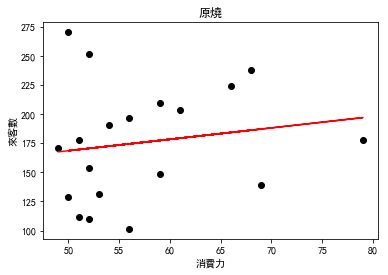

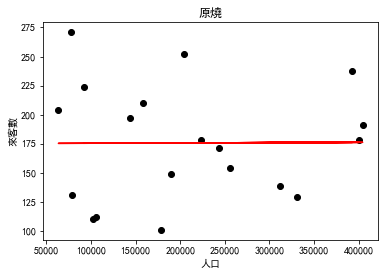

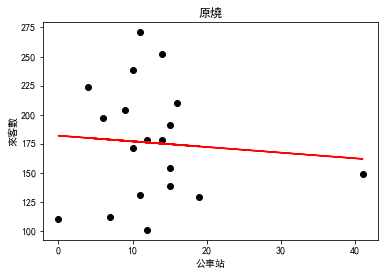

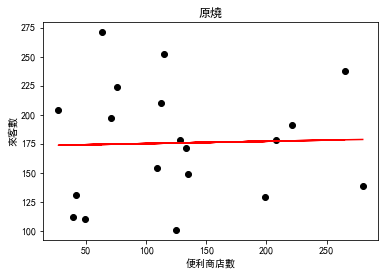

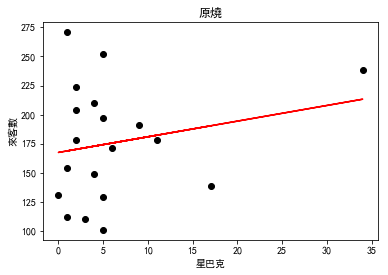

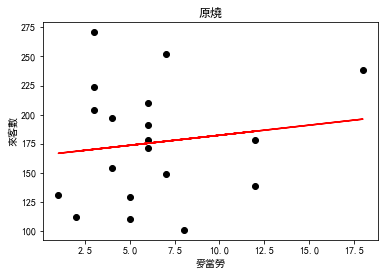

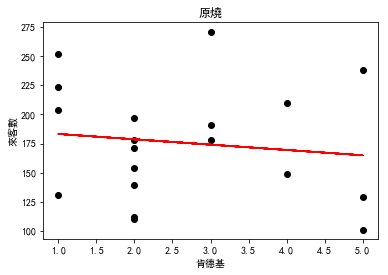

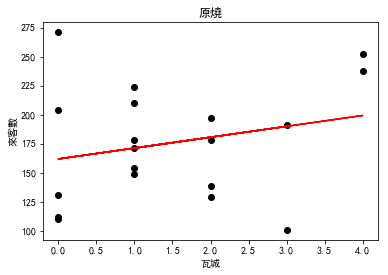

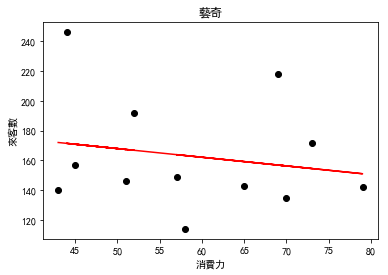

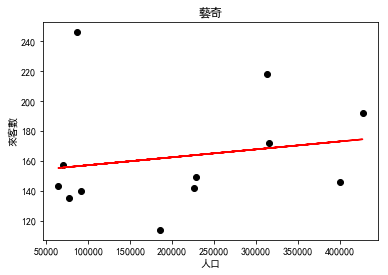

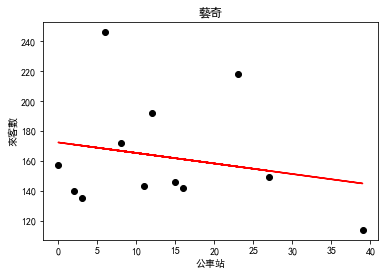

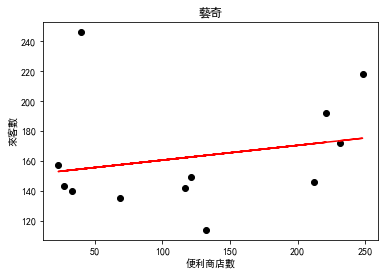

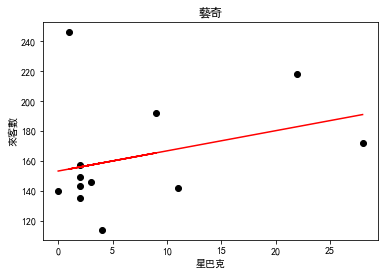

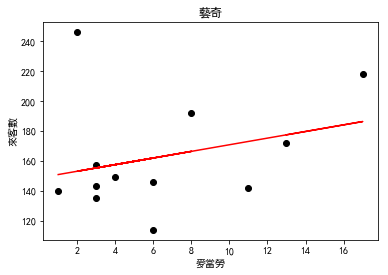

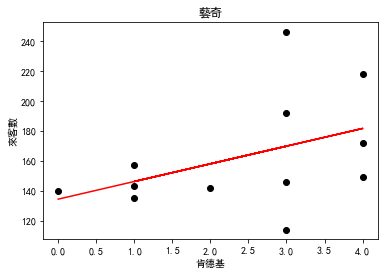

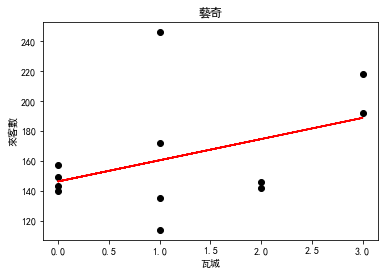

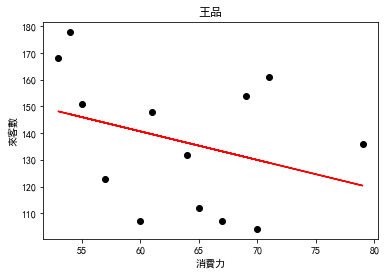

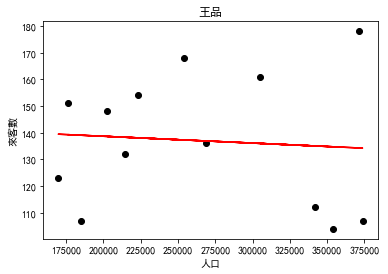

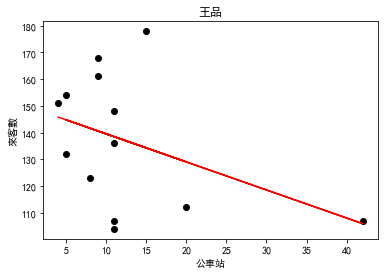

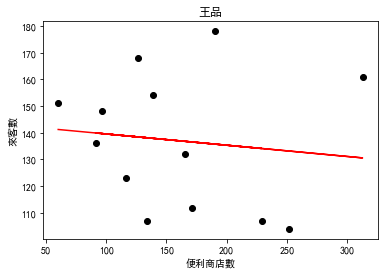

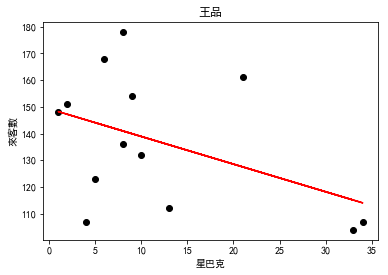

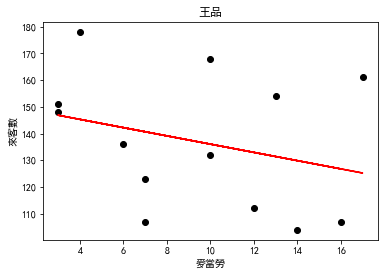

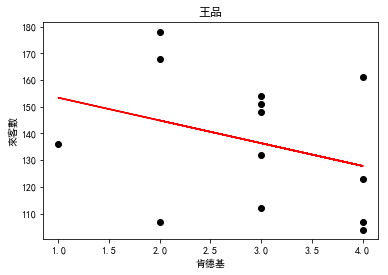

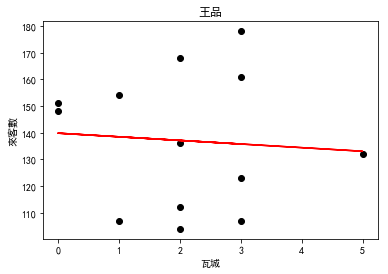

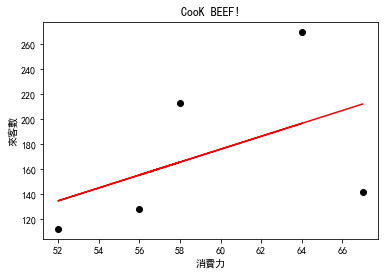

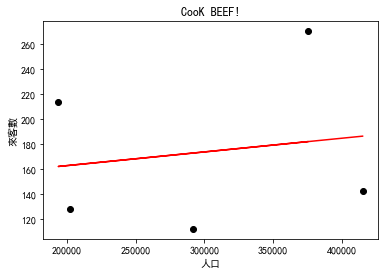

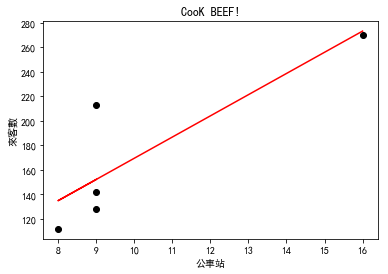

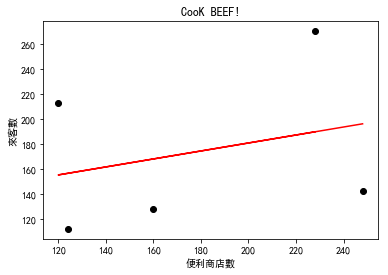

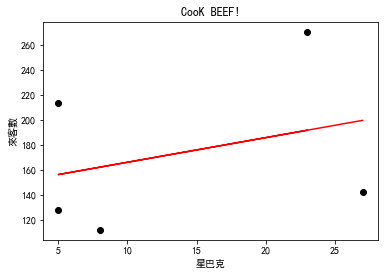

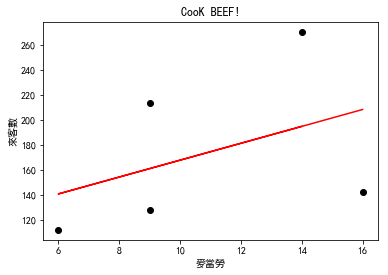

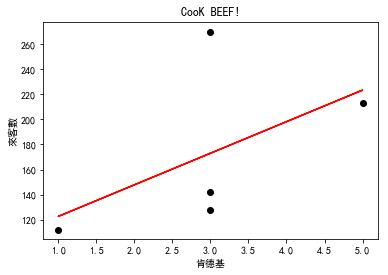

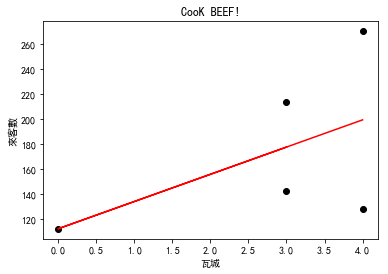

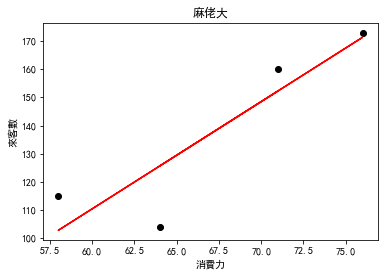

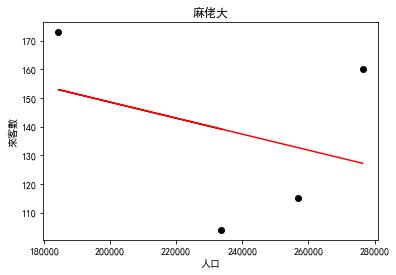

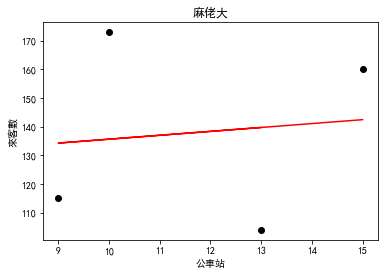

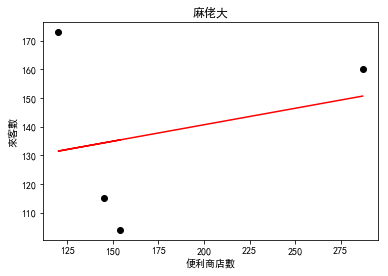

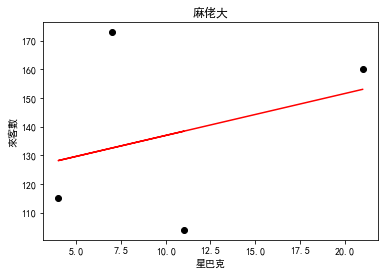

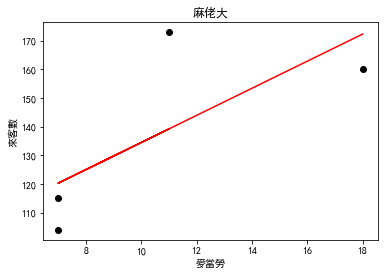

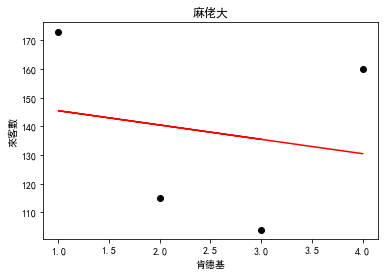

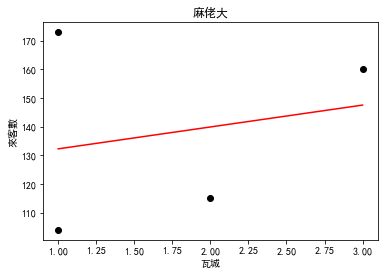

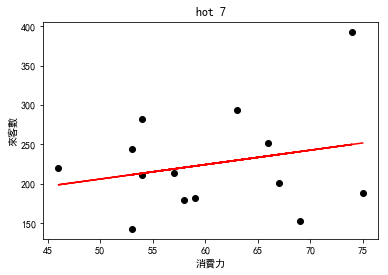

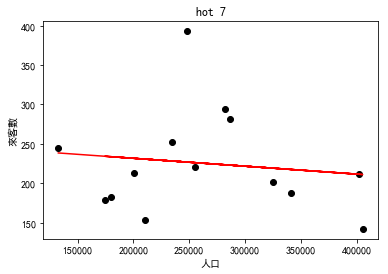

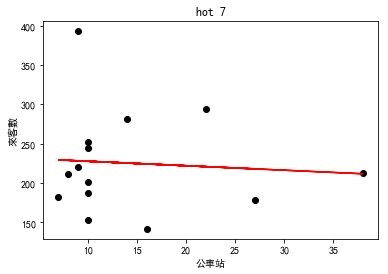

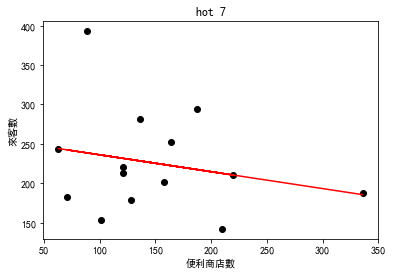

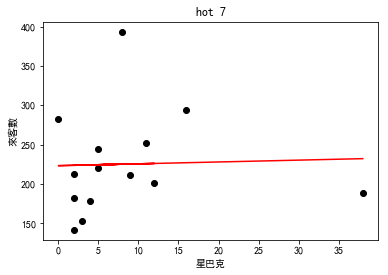

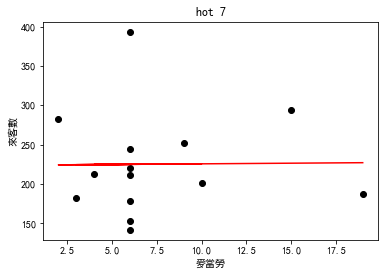

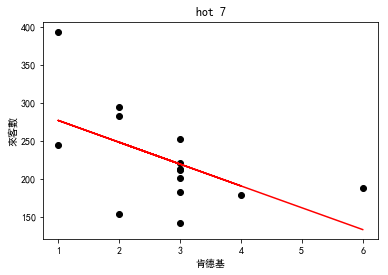

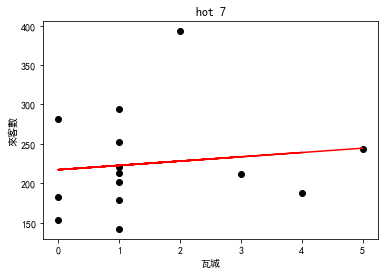

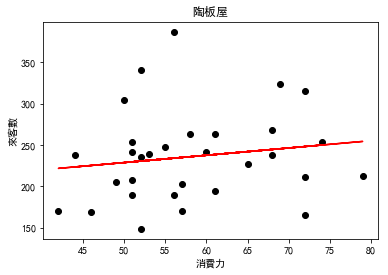

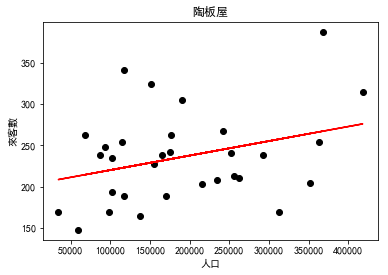

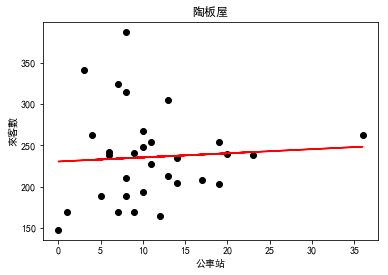

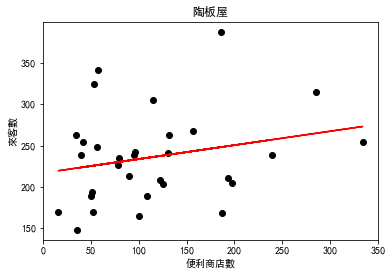

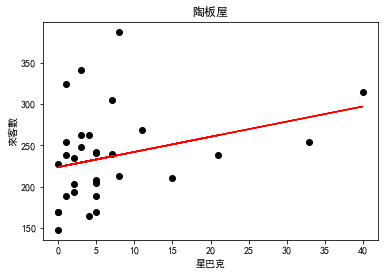

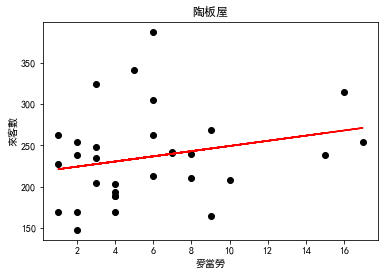

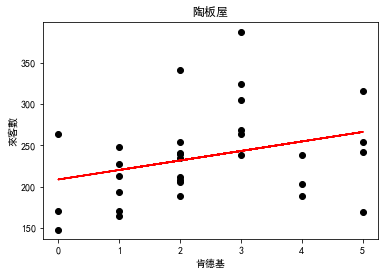

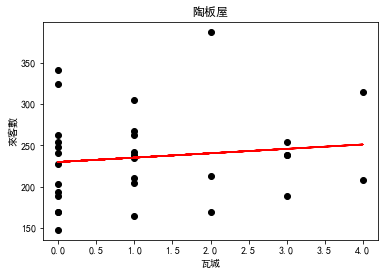

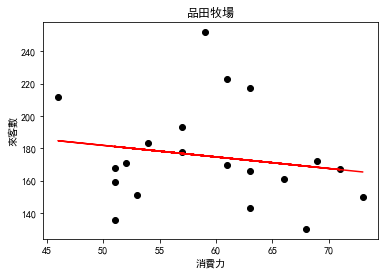

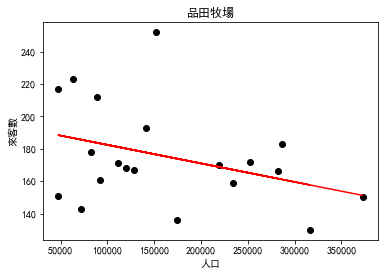

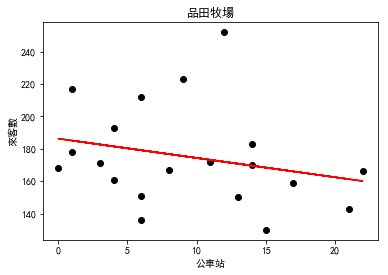

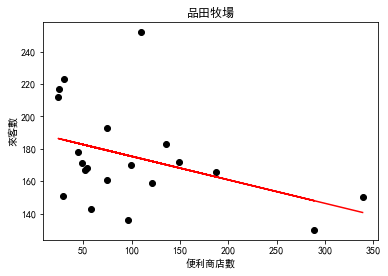

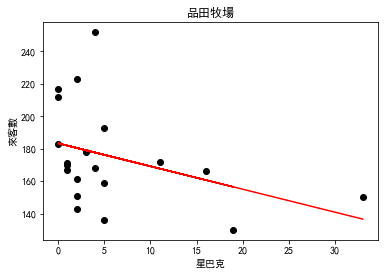

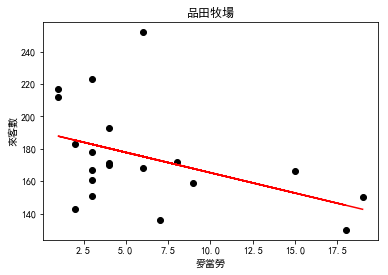

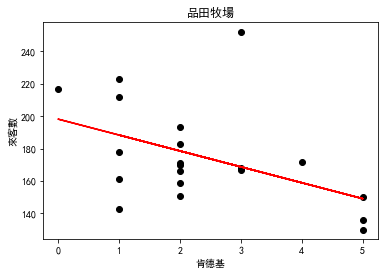

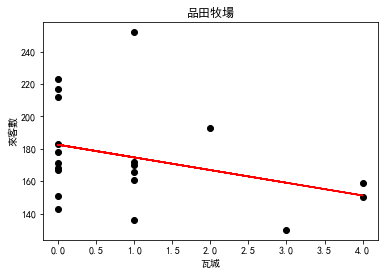

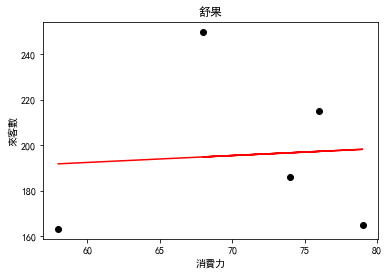

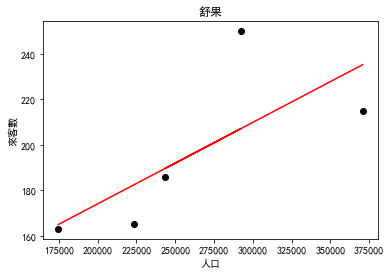

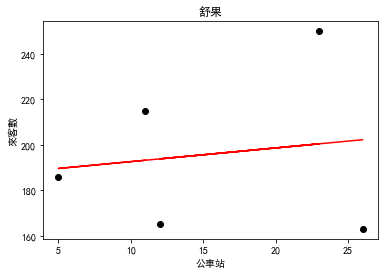

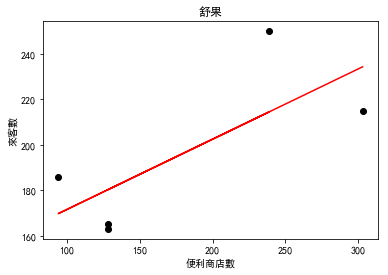

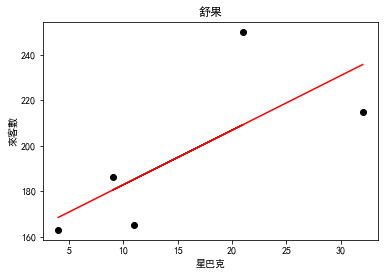

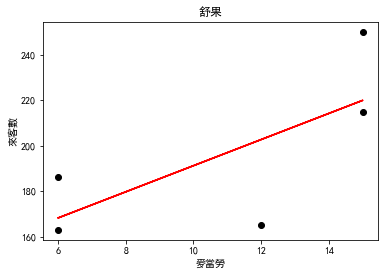

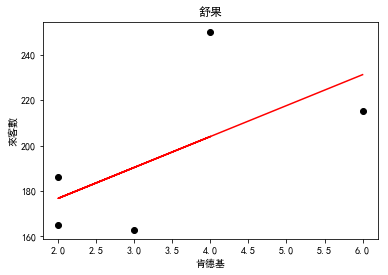

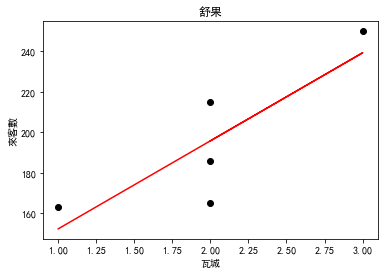

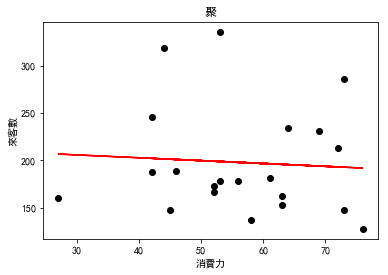

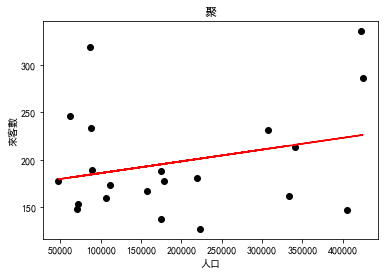

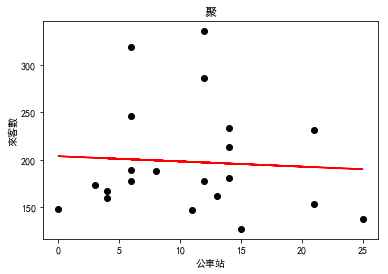

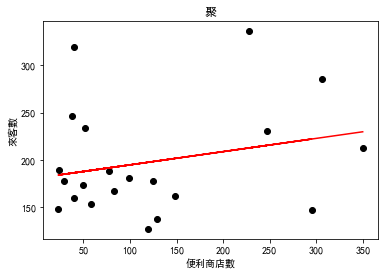

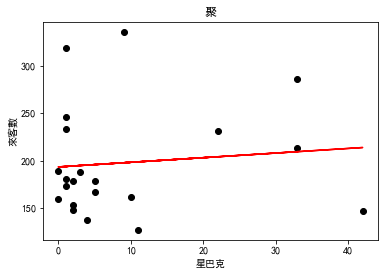

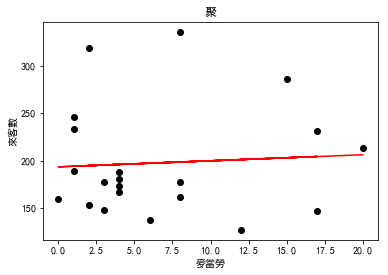

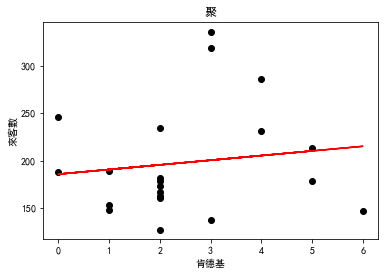

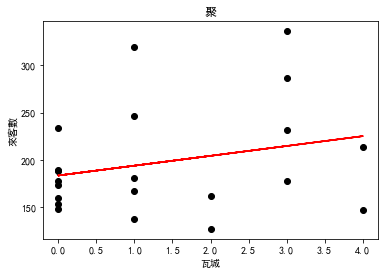

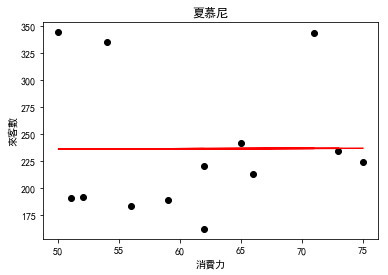

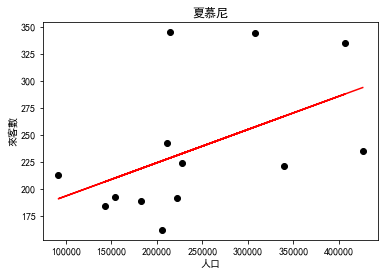

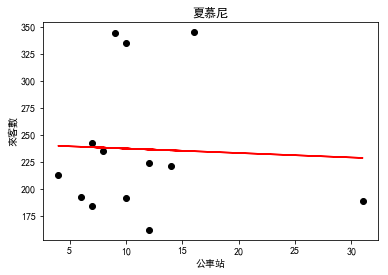

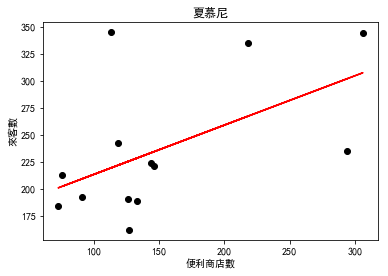

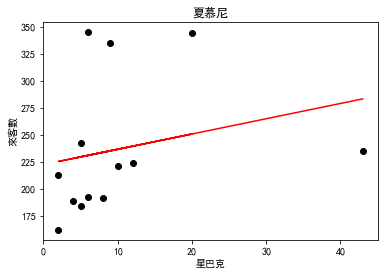

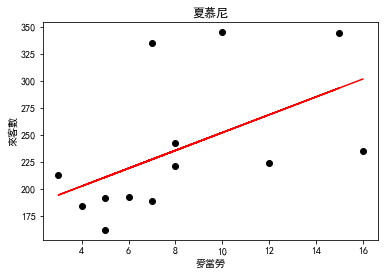

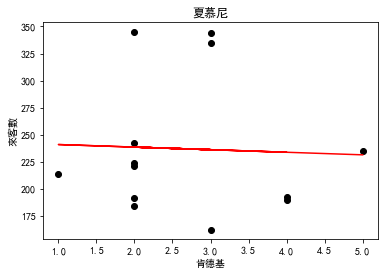

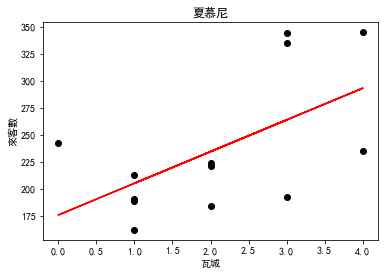

D:\anaconda\lib\site-packages\scipy\optimize\minpack.py:785: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


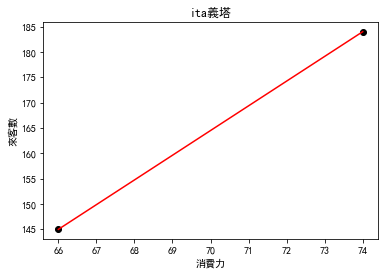

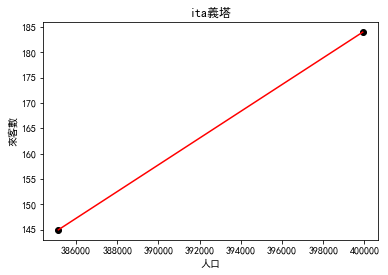

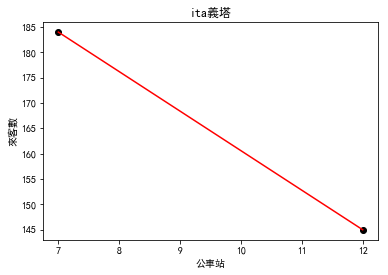

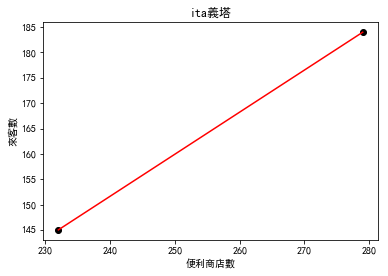

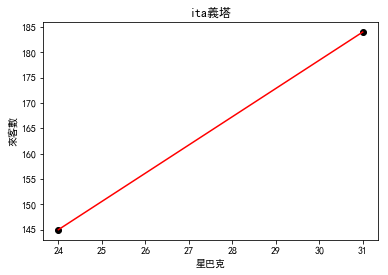

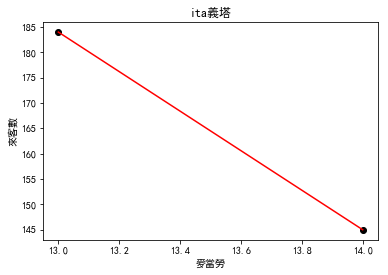

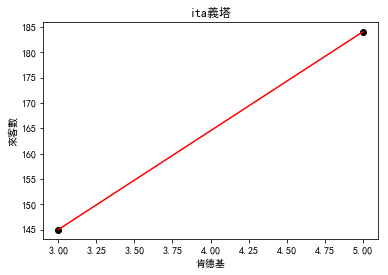

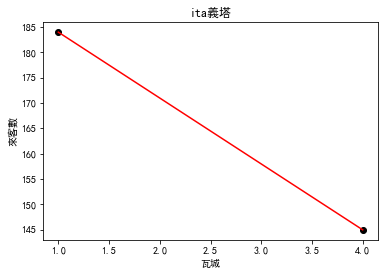

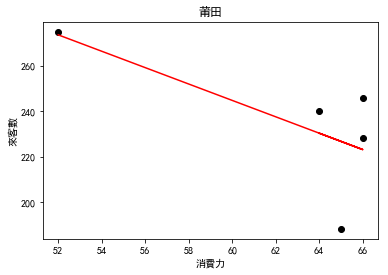

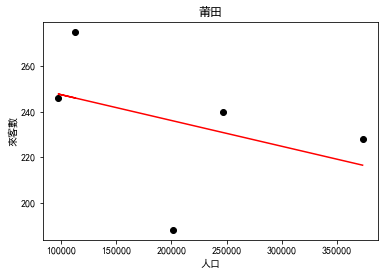

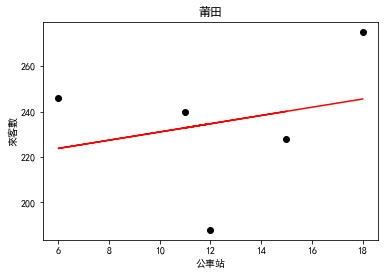

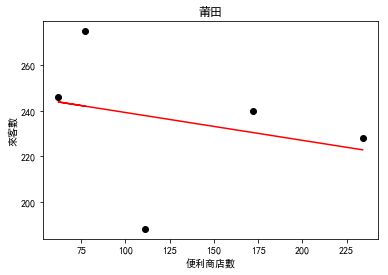

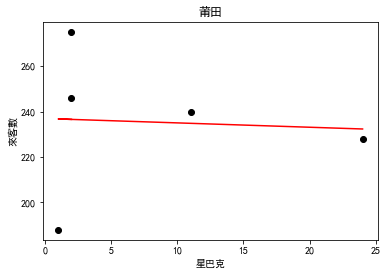

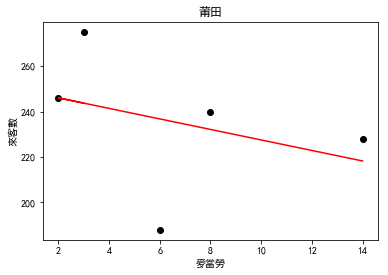

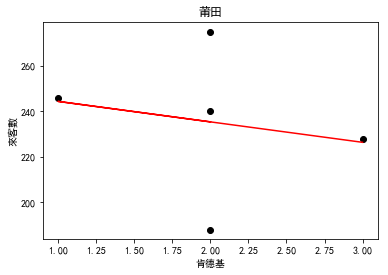

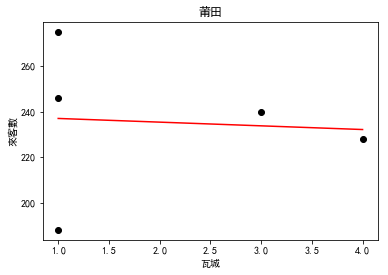

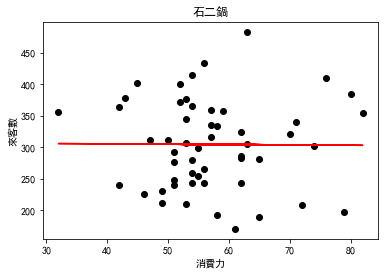

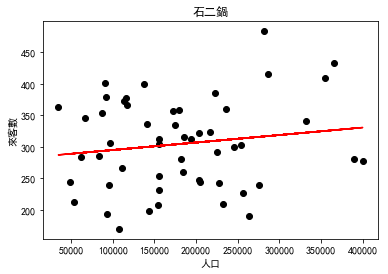

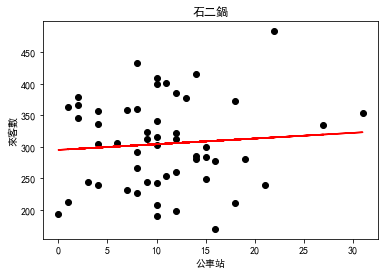

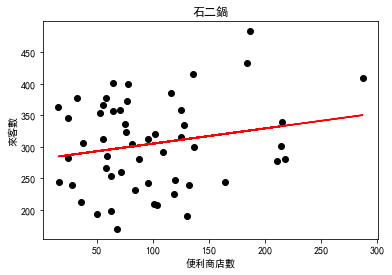

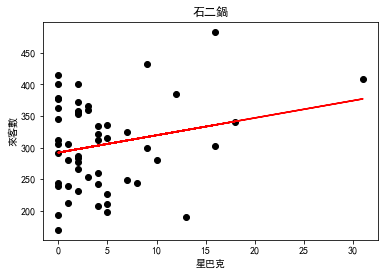

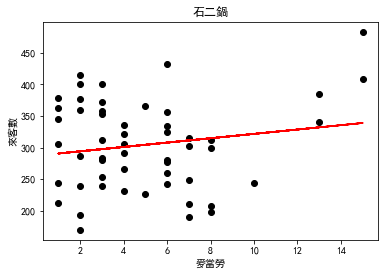

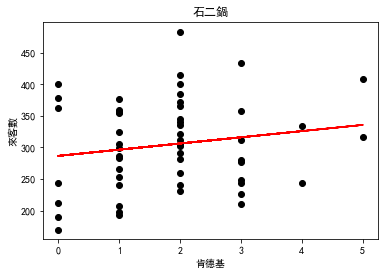

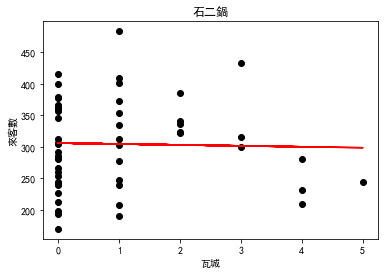

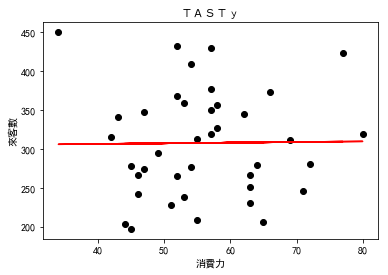

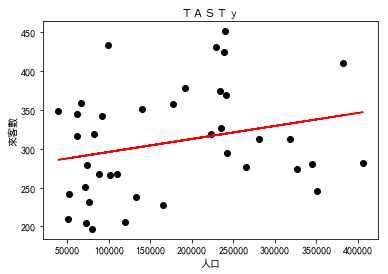

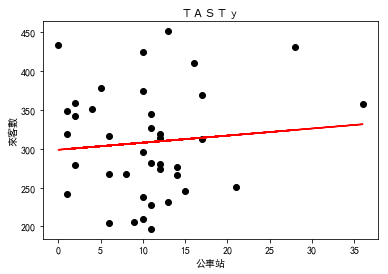

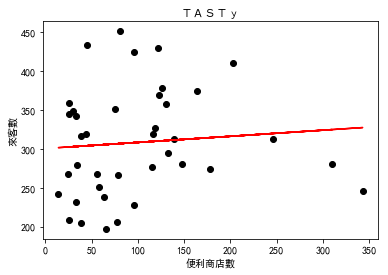

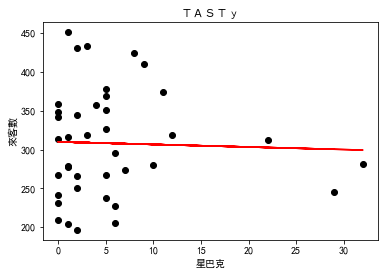

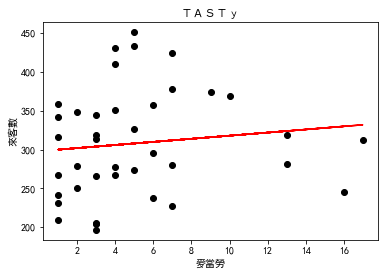

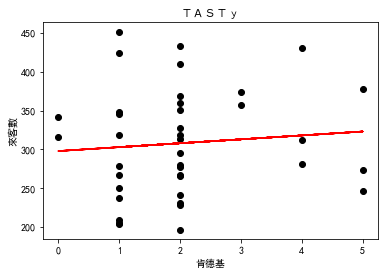

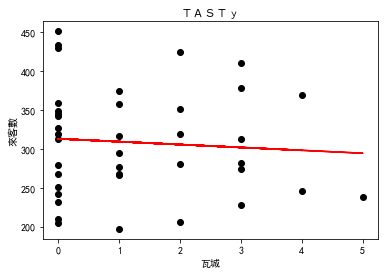

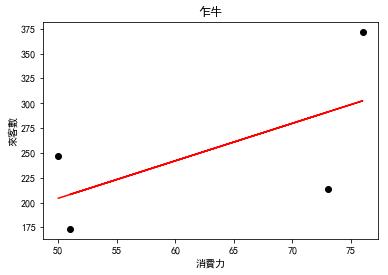

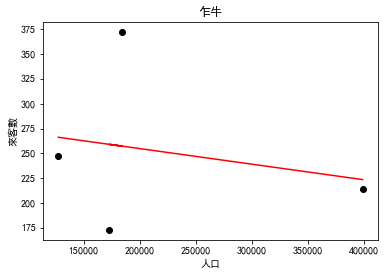

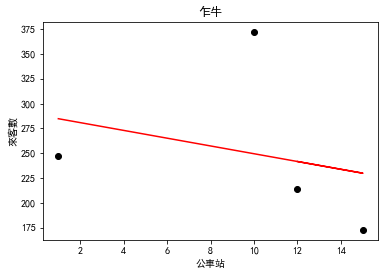

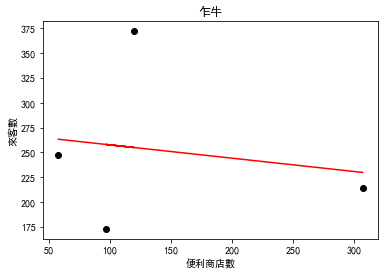

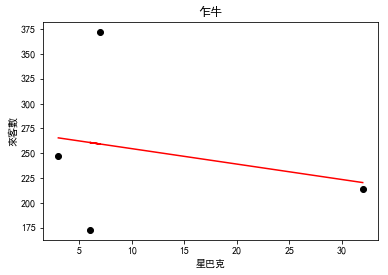

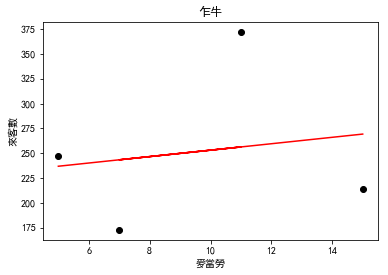

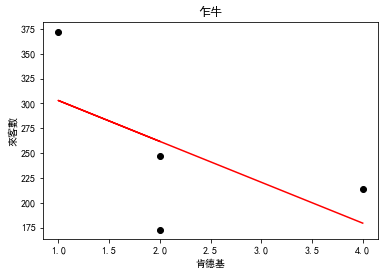

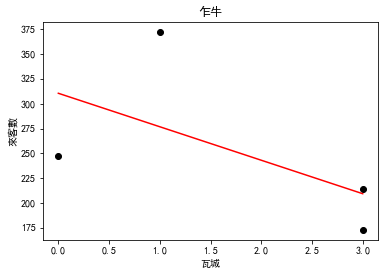

In [31]:
#coding:utf-8
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号
#有中文出现的情况，需要u'内容'


for store in dienCalled:
    for feature in features:
        X= np.array([i[feature] for i in wowDatas if 'NbusStation_Analyze' in i and 'avgDailyCustomer' in i and 'costPower_Analyze' in i
                and i['Called']==store])
        Y= np.array([i['avgDailyCustomer'] for i in wowDatas if 'NbusStation_Analyze' in i and 'avgDailyCustomer' in i and 'costPower_Analyze' in i
                and i['Called']==store])


        xdata=X
        ydata=Y
        def func(x,a,b):
            return a+b*x

        try:
            popt, pcov=curve_fit(func,xdata,ydata)
        except:
            continue
        plt.xlabel(featuremap[feature])
        plt.ylabel('來客數')
        plt.title(store)
        plt.plot(xdata,ydata,'ko',label='Orifinal Noised Data')
        plt.plot(xdata,func(xdata,*popt),'r',label='Fitted Curve')
        plt.show()